In [1]:
import pandas
import geopandas
import matplotlib.pyplot as plt
from fuzzywuzzy import process

In [37]:
df = pandas.read_csv("./GA_precincts_with_absentee.csv")

In [38]:
gdf = geopandas.read_file("./shapefiles/GA_precincts16.shp")

In [70]:
def search_for_match(precinct, county, gdf=gdf, column="PRECINCT_N"):
    choices = gdf[gdf["CTYNAME"] == county][column]
    name, rating, index = process.extractOne(precinct, choices)
    return {"county": county, "precinct": precinct, "rating": rating, "match_index": index}

In [76]:
def find_matches(df, gdf, column="PRECINCT_N"):
    assert set(df["COUNTY"]) == set(gdf["CTYNAME"])
    counties = df["COUNTY"].unique()
    records = [
        search_for_match(precinct, county, gdf=gdf, column=column)
        for county in counties
        for precinct in df[df["COUNTY"] == county]["PRECINCT"]
    ]
    matches = pandas.DataFrame.from_records(records)
    matches["match_value"] = matches["match_index"].map(gdf[column])
    return matches

In [77]:
matches = find_matches(df, gdf)

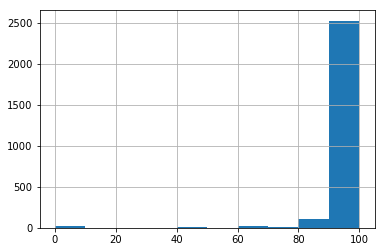

In [119]:
matches.rating.hist()

In [120]:
len(df) - len(gdf)

28

## The problem counties

### Counties with bad match scores:

- Bacon
- Bleckley ✅
- Chatham
- Chattahoochee
- Clarke
- Crawford ✅
- Rockdale
- Spalding ⚠️
- Taylor

### Counties with different numbers of precincts:

- Bibb 1
- Chattooga 1
- Columbia 3
- Crawford 3 ✅
- DeKalb 3
- Effingham 2
- Fayette 2
- Forsyth 4
- Fulton 1
- Gwinnett 1
- Henry 1
- Lowndes 2
- Muscogee 2
- Newton 2
- Pickens 1


In [121]:
for county in counties:
    difference = len(df[df["COUNTY"] == county]) - len(gdf[gdf["CTYNAME"] == county])
    if difference > 0:
        print(county, difference)

Bibb 1
Chattooga 1
Columbia 3
Crawford 3
DeKalb 3
Effingham 2
Fayette 2
Forsyth 4
Fulton 1
Gwinnett 1
Henry 1
Lowndes 2
Muscogee 2
Newton 2
Pickens 1


In [127]:
average_by_county = matches.groupby("county").rating.mean()
average_by_county[average_by_county < 90]

county
Bacon            42.750000
Bleckley          0.000000
Chatham          87.134831
Chattahoochee    86.000000
Clarke           76.500000
Crawford         54.555556
Rockdale         82.777778
Spalding          0.000000
Taylor           56.000000
Name: rating, dtype: float64

### Crawford

In [131]:
crawford = df[df["COUNTY"] == "Crawford"]
crawford_gdf = gdf[gdf["CTYNAME"] == "Crawford"]

In [129]:
columns_to_aggregate = [
    'PRES16D', 'PRES16D_AB', 'PRES16D_AD',
    'PRES16D_ED', 'PRES16D_PR', 'PRES16L', 'PRES16L_AB', 'PRES16L_AD',
    'PRES16L_ED', 'PRES16L_PR', 'PRES16R', 'PRES16R_AB', 'PRES16R_AD',
    'PRES16R_ED', 'PRES16R_PR', 'REG_VOTE'
]

It looks like the shapefile has merged the "COUNTY" and "CITY" parts of each of precincts 1B, 2, and 3 into singular precincts 1B, 2, and 3.

In [138]:
merged_crawford_precincts = crawford.groupby(crawford["PRECINCT"].apply(lambda s: s.split()[0])).sum()
merged_crawford_precincts

,PRES16D,PRES16D_AB,PRES16D_AD,PRES16D_ED,PRES16D_PR,PRES16L,PRES16L_AB,PRES16L_AD,PRES16L_ED,PRES16L_PR,PRES16R,PRES16R_AB,PRES16R_AD,PRES16R_ED,PRES16R_PR,REG_VOTE
PRECINCT,,,,,,,,,,,,,,,,
1A,135,9,45,81,0,3,0,1,2,0,154,3,66,84,1,377
1B,389,29,152,207,1,10,1,4,5,0,225,8,125,92,0,813
2,507,32,334,141,0,24,0,16,8,0,548,39,377,132,0,1385
3,154,7,87,59,1,31,3,9,19,0,875,36,514,325,0,1331
4,126,11,61,54,0,16,0,7,9,0,906,36,398,471,1,1318
5,110,7,47,56,0,22,0,11,11,0,927,31,384,511,1,1301


In [140]:
merged_crawford_precincts.reset_index(inplace=True)
merged_crawford_precincts["COUNTY"] = "Crawford"

In [143]:
assert set(merged_crawford_precincts.columns) == set(df.columns)

In [146]:
merged_crawford_precincts.to_csv("./merged/crawford.csv", index=False)

### Bleckley

In [147]:
df[df["COUNTY"] == "Bleckley"]

,COUNTY,PRECINCT,PRES16D,PRES16D_AB,PRES16D_AD,PRES16D_ED,PRES16D_PR,PRES16L,PRES16L_AB,PRES16L_AD,PRES16L_ED,PRES16L_PR,PRES16R,PRES16R_AB,PRES16R_AD,PRES16R_ED,PRES16R_PR,REG_VOTE
127,Bleckley,FAIRGROUND,1101,113,502,479,7,123,1,66,56,0,3719,136,2076,1505,2,6162


In [148]:
gdf[gdf["CTYNAME"] == "Bleckley"]

,ID,POPULATION,DISTRICT,PRECINCT_I,PRECINCT_N,CTYNAME,FIPS1,FIPS2,PRES16D,PRES16R,...,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,CONDIST,HDIST,SENDIST,geometry
878,1754047,13063,0231,1,1,Bleckley,13023,023,1101,3719,...,2655,7,87,3,0,49,008,144,020,"POLYGON ((-83.337441 32.530466, -83.337288 32...."


This one is just a single precinct in both datasets, and the vote totals match, so I feel good about matching it.

### Spalding

In [149]:
df[df["COUNTY"] == "Spalding"]

,COUNTY,PRECINCT,PRES16D,PRES16D_AB,PRES16D_AD,PRES16D_ED,PRES16D_PR,PRES16L,PRES16L_AB,PRES16L_AD,PRES16L_ED,PRES16L_PR,PRES16R,PRES16R_AB,PRES16R_AD,PRES16R_ED,PRES16R_PR,REG_VOTE
2400,Spalding,SECOND BAPTISH CH,741,27,336,376,2,8,0,3,5,0,101,5,59,37,0,1582
2401,Spalding,FAIRMONT,855,57,414,384,0,11,0,5,6,0,72,3,46,23,0,1588
2402,Spalding,SENIOR CENTER,192,20,120,52,0,39,3,22,14,0,740,39,544,157,0,1254
2403,Spalding,THIRD WARD,180,10,100,70,0,38,1,14,23,0,634,33,397,204,0,1083
2404,Spalding,UGA CAMPUS,975,24,528,422,1,56,2,34,20,0,831,46,589,196,0,2939
2405,Spalding,CITY PARK,839,36,447,356,0,15,0,11,4,0,221,18,141,62,0,1762
2406,Spalding,FIRST METHODIST,227,12,139,76,0,42,3,10,29,0,883,34,588,261,0,1377
2407,Spalding,BOY SCOUTS HDQTRS,267,10,154,103,0,25,4,12,9,0,867,28,600,239,0,1432
2408,Spalding,CABIN,151,3,101,47,0,25,1,12,12,0,927,30,505,391,1,1419
2409,Spalding,CARVER,380,11,203,164,2,27,1,16,10,0,796,32,511,253,0,1500


In [150]:
gdf[gdf["CTYNAME"] == "Spalding"]

,ID,POPULATION,DISTRICT,PRECINCT_I,PRECINCT_N,CTYNAME,FIPS1,FIPS2,PRES16D,PRES16R,...,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,CONDIST,HDIST,SENDIST,geometry
165,1054638,3210,25514,14,19,Spalding,13255,255,235,722,...,316,7,8,0,3,8,003,073,016,"POLYGON ((-84.247136 33.338347, -84.247125 33...."
595,1089620,2656,25509,09,04,Spalding,13255,255,151,927,...,132,5,10,0,1,24,003,130,016,"POLYGON ((-84.08899099999999 33.285646, -84.08..."
598,816003,829,25515,15,02,Spalding,13255,255,44,368,...,9,3,2,0,0,2,003,073,016,"POLYGON ((-84.50851299999999 33.239846, -84.50..."
610,989093,2143,25512,12,15,Spalding,13255,255,177,766,...,160,3,7,0,0,11,003,073,016,"POLYGON ((-84.437512 33.208678, -84.442915 33...."
611,989165,3714,25519,19,11,Spalding,13255,255,405,1248,...,426,11,26,0,1,23,003,073,016,"(POLYGON ((-84.419723 33.289229, -84.419655000..."
654,1015373,1822,25503,03,18,Spalding,13255,255,192,740,...,106,2,13,0,0,9,003,130,016,"POLYGON ((-84.244934 33.229792, -84.2449309999..."
655,1015495,3276,25502,02,10,Spalding,13255,255,855,72,...,2000,7,3,4,0,17,003,130,016,"POLYGON ((-84.243694 33.248529, -84.243719 33...."
656,1015584,2322,25518,18,07,Spalding,13255,255,759,123,...,1263,6,0,5,0,21,003,073,016,"POLYGON ((-84.253989 33.303513, -84.247848 33...."
657,1015655,3019,25517,17,01,Spalding,13255,255,347,672,...,508,6,3,3,0,25,003,130,016,"(POLYGON ((-84.22183200000001 33.234187, -84.2..."
658,1063865,3170,25521,21,09,Spalding,13255,255,931,1720,...,399,6,9,1,1,18,003,130,016,"POLYGON ((-84.136798 33.308318, -84.1366419999..."


This one is wild! I suppose our next course of action is try and figure out where these landmarks ("SENIOR CENTER", "CITY PARK") are and then match that to our precinct geometries. We could also talk to the county for more information.

### Bacon

In [151]:
df[df["COUNTY"] == "Bacon"]

,COUNTY,PRECINCT,PRES16D,PRES16D_AB,PRES16D_AD,PRES16D_ED,PRES16D_PR,PRES16L,PRES16L_AB,PRES16L_AD,PRES16L_ED,PRES16L_PR,PRES16R,PRES16R_AB,PRES16R_AD,PRES16R_ED,PRES16R_PR,REG_VOTE
18,Bacon,Pearson County,136,10,66,59,1,6,0,1,5,0,850,25,550,271,4,1339
19,Bacon,Axson,29,2,12,15,0,4,0,1,3,0,375,10,144,221,0,561
20,Bacon,Willacoochee,257,4,74,179,0,16,1,3,12,0,489,14,191,283,1,1064
21,Bacon,Pearson City,275,14,147,114,0,9,0,5,4,0,164,9,87,68,0,731


In [152]:
gdf[gdf["CTYNAME"] == "Bacon"]

,ID,POPULATION,DISTRICT,PRECINCT_I,PRECINCT_N,CTYNAME,FIPS1,FIPS2,PRES16D,PRES16R,...,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,CONDIST,HDIST,SENDIST,geometry
728,2300131,1978,005NEW L,NEW L,NEW LACY,Bacon,13005,005,58,696,...,109,3,1,1,0,7,001,169,007,"POLYGON ((-82.31152299999999 31.590997, -82.31..."
787,1443845,848,005WARE,WARE,WARE,Bacon,13005,005,25,328,...,17,0,1,0,0,4,001,169,007,"POLYGON ((-82.455321 31.491416, -82.453571 31...."
1082,2292290,1483,005TAYLO,TAYLO,TAYLOR,Bacon,13005,005,30,521,...,31,0,3,0,0,7,001,169,007,"POLYGON ((-82.595156 31.53239, -82.59652199999..."
1083,2292423,520,005WARNO,WARNO,WARNOCK,Bacon,13005,005,18,241,...,6,0,2,0,0,5,001,169,007,"POLYGON ((-82.40184000000001 31.63957, -82.401..."
1091,2285630,6267,005DOUGL,DOUGL,DOUGLAS,Bacon,13005,005,477,1578,...,1022,4,20,5,1,26,001,169,007,"POLYGON ((-82.433916 31.504452, -82.434225 31...."


## Errors in the data concatenation

It looks like we read in some of the counties' data wrong. This might be the cause of these discrepancies in the vote totals between our two datasets:

In [168]:
errors_r = (df.groupby("COUNTY")["PRES16R"].sum() - gdf["PRES16R"].astype(int).groupby(gdf["CTYNAME"]).sum())

In [169]:
errors_r[errors_r != 0]

COUNTY
Bacon           -1486
Barrow          -6730
Chatham         -8920
Chattahoochee    -471
Columbia         -363
DeKalb            490
Douglas          -440
Effingham       -1432
Morgan           1022
Name: PRES16R, dtype: int64

In [177]:
errors_d = (df.groupby("COUNTY")["PRES16D"].sum() - gdf["PRES16D"].astype(int).groupby(gdf["CTYNAME"]).sum())
errors_d[errors_d != 0]

COUNTY
Bacon               89
Barrow           -1501
Chatham         -34984
Chattahoochee     -567
Columbia          -666
DeKalb           -1727
Douglas           -408
Morgan             298
Name: PRES16D, dtype: int64

You can see that, at least for Chatham, the names of the precincts were too long and extended all the way to the first vote totals without a whitespace separator:

In [174]:
df[df["COUNTY"] == "Chatham"]["PRECINCT"]

255                   1-01 First Presbyterian Church2826
256                                  1-05 J E A Building
257                   1-06 Central Church of Christ 1752
258               1-08 Grace United Methodist Church1384
259                         1-09 Immanuel Baptist Church
260                  1-10 St. Thomas Episcopal Church943
261                 1-12 Isle of Hope Baptist Center1747
262                                   1-13 The Sanctuary
263            1-14 St. Luke United Methodist Church1417
264                 1-16 Ferguson Ave Baptist Church2261
265                   1-17 Islands Christian Church 2646
266                 2-02 Blackshear Community Center1403
267                                2-03 W. W. Law Center
268         2-04 Fellowship of Love Community Church2562
269                 2-05 Holy Spirit Lutheran Church1712
270                             2-06 Eli Whitney Complex
271      2-07 Christ Community Church at Morningside2270
272                            

That parsing error is throwing off the vote totals. :(